In [39]:
import pandas as pd
import statsmodels.api as sm
%matplotlib inline

path = '/Users/tdobbins/Desktop/zbp.csv'
sample = pd.read_csv(path)

In [40]:
sample.head()

,sq_miles,HC03_VC96,HC01_VC03,HC01_VC103,HC03_VC67,HC03_VC68,HC03_VC88,HC03_VC49,HC01_VC88,HC03_VC135,HC03_VC136,HC03_VC92,HC03_VC12,HC03_VC41,HC03_VC43,HC03_VC161,HC01_VC118,HC03_VC171,zip,grocery_stores,restaurants,manufacturing,tech,colleges,total,shopping_centers,new_homes,hotels,car_dealers,taxis,airport_related,starbucks_count,HC01_VC03_sqrt,num_of_sb,City,State,has_starbucks
0,4.439851,36.3,7013,1394,78.0,9.4,27.3,71.8,1677,1.3,27.3,14.0,9.8,34.4,19.6,11.3,56976,18.7,89109,156,1536,24,13,32,2556,15,18,90,9,6,2,25,83.743656,625,Las Vegas,NV,t
1,0.524270,56.9,10803,1562,87.6,8.0,11.9,73.9,668,1.7,20.6,24.5,6.1,61.3,19.8,10.7,62253,18.9,98101,228,1124,36,49,80,2919,22,12,162,3,3,4,23,103.937481,529,Seattle,WA,t
2,4.944263,53.2,35893,4647,81.4,11.3,10.9,75.4,7247,1.5,21.3,19.5,7.6,56.0,22.0,11.8,49269,24.3,92101,184,1828,8,22,208,3982,38,62,273,3,15,30,23,189.454480,529,San Diego,CA,t
3,0.327078,80.9,16278,2673,88.3,7.8,5.5,72.6,1120,1.5,31.9,36.9,3.6,69.7,22.9,5.3,104324,7.2,10017,260,1344,20,52,240,4963,104,34,582,3,6,11,20,127.585266,400,New York,NY,t
4,0.678290,70.6,38752,6111,88.6,5.3,9.7,72.5,6560,2.2,31.4,33.6,6.1,68.5,19.0,8.1,86447,11.8,10019,344,2192,24,35,232,4939,70,46,699,30,39,5,17,196.855277,289,New York,NY,t


In [41]:
sample = sample.fillna(0)

In [43]:
sample.has_starbucks = sample.has_starbucks.replace('t', 1)
sample.has_starbucks = sample.has_starbucks.replace('f', 0)

In [44]:
sample

,sq_miles,HC03_VC96,HC01_VC03,HC01_VC103,HC03_VC67,HC03_VC68,HC03_VC88,HC03_VC49,HC01_VC88,HC03_VC135,HC03_VC136,HC03_VC92,HC03_VC12,HC03_VC41,HC03_VC43,HC03_VC161,HC01_VC118,HC03_VC171,zip,grocery_stores,restaurants,manufacturing,tech,colleges,total,shopping_centers,new_homes,hotels,car_dealers,taxis,airport_related,starbucks_count,HC01_VC03_sqrt,num_of_sb,City,State,has_starbucks
0,4.439851,36.3,7013,1394,78.0,9.4,27.3,71.8,1677,1.3,27.3,14.0,9.8,34.4,19.6,11.3,56976,18.7,89109,156,1536,24,13,32,2556,15,18,90,9,6,2,25,83.743656,625,Las Vegas,NV,1
1,0.524270,56.9,10803,1562,87.6,8.0,11.9,73.9,668,1.7,20.6,24.5,6.1,61.3,19.8,10.7,62253,18.9,98101,228,1124,36,49,80,2919,22,12,162,3,3,4,23,103.937481,529,Seattle,WA,1
2,4.944263,53.2,35893,4647,81.4,11.3,10.9,75.4,7247,1.5,21.3,19.5,7.6,56.0,22.0,11.8,49269,24.3,92101,184,1828,8,22,208,3982,38,62,273,3,15,30,23,189.454480,529,San Diego,CA,1
3,0.327078,80.9,16278,2673,88.3,7.8,5.5,72.6,1120,1.5,31.9,36.9,3.6,69.7,22.9,5.3,104324,7.2,10017,260,1344,20,52,240,4963,104,34,582,3,6,11,20,127.585266,400,New York,NY,1
4,0.678290,70.6,38752,6111,88.6,5.3,9.7,72.5,6560,2.2,31.4,33.6,6.1,68.5,19.0,8.1,86447,11.8,10019,344,2192,24,35,232,4939,70,46,699,30,39,5,17,196.855277,289,New York,NY,1
5,10.728244,52.7,41453,9127,76.6,13.7,12.1,61.6,7119,1.5,18.1,21.8,8.4,56.1,23.5,7.0,41422,11.0,90045,68,636,4,27,108,2039,14,38,84,12,48,90,16,203.600098,256,Los Angeles,CA,1
6,10.728244,52.7,41453,9127,76.6,13.7,12.1,61.6,7119,1.5,18.1,21.8,8.4,56.1,23.5,7.0,41422,11.0,90045,68,636,4,27,108,2039,14,38,84,12,48,90,16,203.600098,256,Westchester,CA,1
7,1.099264,68.7,11474,1397,86.3,8.0,8.1,87.3,1065,1.3,5.5,26.0,6.4,67.1,20.9,3.7,68832,15.9,80202,112,1164,0,39,108,3113,23,18,120,3,0,1,15,107.116759,225,Denver,CO,1
8,8.636586,68.7,31254,7878,90.0,4.6,8.1,69.9,1128,2.0,33.0,28.0,6.1,63.9,20.8,5.5,68924,8.0,98004,84,784,4,35,220,2940,25,88,195,24,6,1,15,176.788009,225,Bellevue,WA,1
9,0.435700,68.1,24127,2990,87.3,4.7,10.0,66.9,4102,2.7,31.8,29.7,7.9,64.6,20.1,4.3,72435,12.0,10036,240,2040,28,27,188,6230,94,36,546,15,18,1,14,155.328684,196,New York,NY,1


In [ ]:
'shopping_centers', 'HC03_VC88', 'airport_related', 'colleges'

In [68]:
#########################
# GLM model, results
#########################

admit_yn = sample.has_starbucks
score = sample.shopping_centers
# score = sample.GP5

score_with_intercept = sm.add_constant(score)

model = sm.GLM(admit_yn, score_with_intercept, family=sm.families.Binomial())
result = model.fit()

In [80]:
result.fittedvalues

0        1.872171 
1        7.345897 
2        20.789329
3        31.204144
4        23.731479
5        20.582899
6        20.582899
7        8.882400 
8        15.060090
9        24.843879
10       10.456705
11       6.591948 
12       30.655674
13       53.877012
14       12.652430
15       11.113140
16       10.654774
17       5.011436 
18       1.227968 
19       9.865654 
20       13.106670
21       11.805387
22       9.397875 
23       8.595969 
24       10.527232
25       19.231625
26       5.586448 
27       6.472409 
28       9.344553 
29       9.344553 
           ...    
32482   -5.379104 
32483   -0.080613 
32484   -1.543502 
32485   -2.545214 
32486   -1.875035 
32487   -3.778869 
32488   -0.804281 
32489   -0.858930 
32490   -2.837644 
32491   -2.987124 
32492   -5.504423 
32493   -2.550504 
32494   -3.581310 
32495   -2.452717 
32496   -2.489345 
32497   -4.260867 
32498   -4.781426 
32499   -3.518589 
32500   -2.467833 
32501   -6.246701 
32502   -4.704306 
32503   -3.6

In [69]:
print result.summary()

DEBUG:root:Enter SimpleTable.data2rows.
DEBUG:root:Exit SimpleTable.data2rows.
DEBUG:root:Enter SimpleTable.data2rows.
DEBUG:root:Exit SimpleTable.data2rows.
DEBUG:root:Enter SimpleTable.data2rows.
DEBUG:root:Exit SimpleTable.data2rows.


                 Generalized Linear Model Regression Results                  
Dep. Variable:          has_starbucks   No. Observations:                32512
Model:                            GLM   Df Residuals:                    32510
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 08 Apr 2017   Deviance:                       20620.
Time:                        09:24:14   Pearson chi2:                 2.54e+12
No. Iterations:                     9                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -2.5783      0.023   -111.722      0.000        -2.624    -2.533
shopping_centers     0.7243      0

In [70]:
import pylab as plt
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import statsmodels.api as sm
import re
from scipy import stats
from utilitybelt import UtilityBelt as ub
from tabulate import tabulate
from fpdf import FPDF
import os
from PyPDF2 import PdfFileReader, PdfFileMerger

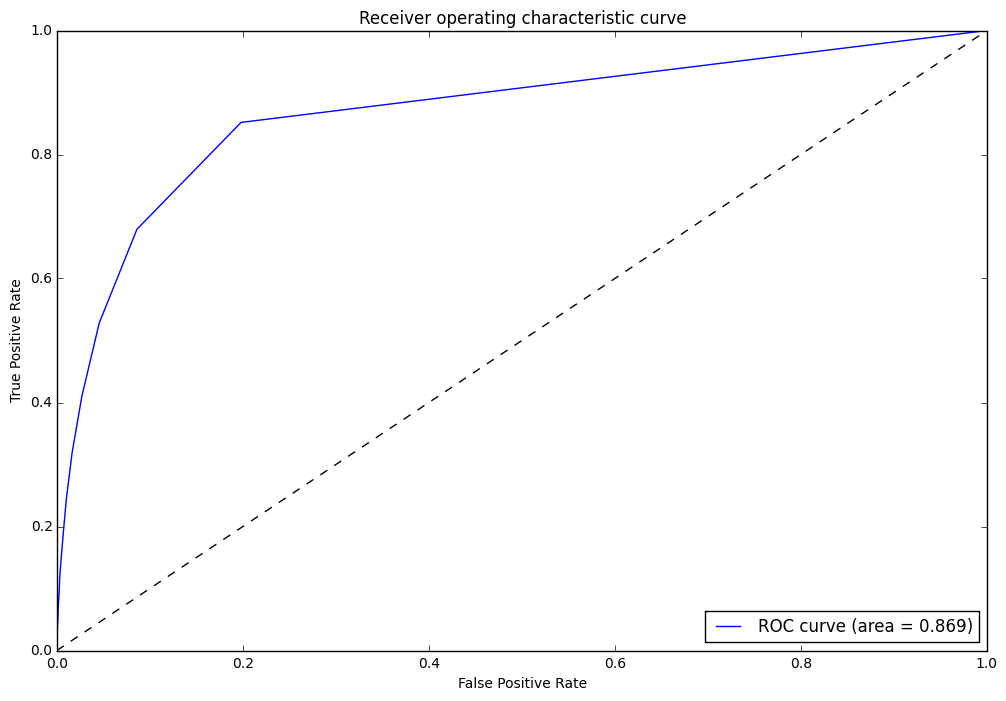

In [71]:
admit_array = np.asarray(admit_yn)
pred = np.asarray(score)

# retrieve false-positive rates and true-positive rates
fpr, tpr, thresholds = metrics.roc_curve(admit_array, pred, pos_label=1)
metrics.auc(fpr, tpr)

#compute area under curve 
roc_auc = auc(fpr, tpr)

# plotting the ROC curve
roc_curve = plt.figure(figsize=(12,8))
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)

# dashed line through the origin
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [48]:
sample.head()

,sq_miles,HC03_VC96,HC01_VC03,HC01_VC103,HC03_VC67,HC03_VC68,HC03_VC88,HC03_VC49,HC01_VC88,HC03_VC135,HC03_VC136,HC03_VC92,HC03_VC12,HC03_VC41,HC03_VC43,HC03_VC161,HC01_VC118,HC03_VC171,zip,grocery_stores,restaurants,manufacturing,tech,colleges,total,shopping_centers,new_homes,hotels,car_dealers,taxis,airport_related,starbucks_count,HC01_VC03_sqrt,num_of_sb,City,State,has_starbucks
0,4.439851,36.3,7013,1394,78.0,9.4,27.3,71.8,1677,1.3,27.3,14.0,9.8,34.4,19.6,11.3,56976,18.7,89109,156,1536,24,13,32,2556,15,18,90,9,6,2,25,83.743656,625,Las Vegas,NV,1
1,0.524270,56.9,10803,1562,87.6,8.0,11.9,73.9,668,1.7,20.6,24.5,6.1,61.3,19.8,10.7,62253,18.9,98101,228,1124,36,49,80,2919,22,12,162,3,3,4,23,103.937481,529,Seattle,WA,1
2,4.944263,53.2,35893,4647,81.4,11.3,10.9,75.4,7247,1.5,21.3,19.5,7.6,56.0,22.0,11.8,49269,24.3,92101,184,1828,8,22,208,3982,38,62,273,3,15,30,23,189.454480,529,San Diego,CA,1
3,0.327078,80.9,16278,2673,88.3,7.8,5.5,72.6,1120,1.5,31.9,36.9,3.6,69.7,22.9,5.3,104324,7.2,10017,260,1344,20,52,240,4963,104,34,582,3,6,11,20,127.585266,400,New York,NY,1
4,0.678290,70.6,38752,6111,88.6,5.3,9.7,72.5,6560,2.2,31.4,33.6,6.1,68.5,19.0,8.1,86447,11.8,10019,344,2192,24,35,232,4939,70,46,699,30,39,5,17,196.855277,289,New York,NY,1


In [50]:
sample[['shopping_centers', 'tech', 'HC03_VC88', 'airport_related', 'colleges']]
grocery_stores	restaurants	manufacturing	tech	colleges	total

KeyError: ('shopping_centers', 'tech', 'HC03_VC88', 'airport_related', 'colleges')

In [83]:
sample['predict'] = result.predict(sample[['shopping_centers', 'HC03_VC88', 'airport_related', 'colleges']])

In [90]:
predict = sample[['shopping_centers', 'HC03_VC88', 'airport_related', 'colleges', 'predict', 'has_starbucks', 'zip']]

In [92]:
predict[predict.has_starbucks==0]

,shopping_centers,HC03_VC88,airport_related,colleges,predict,has_starbucks,zip
5444,0,0.0,0,8,0.602807,0,82073
5445,0,80.0,0,4,0.000551,0,6856
5446,0,39.7,0,0,0.021309,0,98174
5447,0,0.0,0,0,0.500000,0,98164
5448,0,50.0,0,0,0.008002,0,17077
5449,0,54.5,0,0,0.005201,0,15621
5450,0,31.6,0,0,0.045380,0,20390
5451,0,0.0,0,0,0.500000,0,79920
5452,0,46.7,0,0,0.010967,0,17250
5453,0,81.8,0,4,0.000463,0,20118


In [76]:
# train_cols = data.columns[1:]
# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)

logit = sm.Logit(sample['has_starbucks'], sample[['shopping_centers', 'HC03_VC88', 'airport_related', 'colleges']])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.243896
         Iterations 7


In [77]:
print result.summary()

DEBUG:root:Enter SimpleTable.data2rows.
DEBUG:root:Exit SimpleTable.data2rows.
DEBUG:root:Enter SimpleTable.data2rows.
DEBUG:root:Exit SimpleTable.data2rows.
DEBUG:root:Enter SimpleTable.data2rows.
DEBUG:root:Exit SimpleTable.data2rows.


                           Logit Regression Results                           
Dep. Variable:          has_starbucks   No. Observations:                32512
Model:                          Logit   Df Residuals:                    32508
Method:                           MLE   Df Model:                            3
Date:                Sat, 08 Apr 2017   Pseudo R-squ.:                  0.4602
Time:                        09:24:45   Log-Likelihood:                -7929.5
converged:                       True   LL-Null:                       -14689.
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
shopping_centers     0.1686      0.012     13.731      0.000         0.145     0.193
HC03_VC88           -0.0964      0.001    -96.782      0.000        -0.098    -0.094
airport_related      0.1529 